# Phase 1: Exploratory Data Analysis

This notebook explores the Telco Customer Churn dataset and generates synthetic interventions
to create a causal inference problem.

## Objectives
1. Load and explore the raw dataset
2. Analyze baseline churn rates and patterns
3. Segment analysis by tenure, contract, service
4. Visualize key correlations
5. Generate synthetic interventions with selection bias

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
sys.path.append('..')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

## 1. Load and Explore Data

In [2]:
# Load raw data
df = pd.read_csv('../data/raw/telco_churn.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Total Customers: {len(df):,}")
print(f"Features: {df.shape[1]}")
print("\n" + "="*60)
print("Column Names:")
print(df.columns.tolist())

Dataset Shape: (7043, 21)
Total Customers: 7,043
Features: 21

Column Names:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [3]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# First look at the data
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [5]:
# Data cleaning: Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Missing TotalCharges: {df['TotalCharges'].isna().sum()}")

# Fill missing with 0 (new customers)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Create binary churn column
df['Churn_binary'] = (df['Churn'] == 'Yes').astype(int)

Missing TotalCharges: 11


## 2. Baseline Churn Statistics

In [6]:
# Overall churn rate
print("=" * 50)
print("CHURN DISTRIBUTION")
print("=" * 50)

churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

for label in ['No', 'Yes']:
    print(f"{label:5}: {churn_counts[label]:,} customers ({churn_pct[label]:.2f}%)")

baseline_churn = churn_pct['Yes']
print(f"\nBaseline Churn Rate: {baseline_churn:.2f}%")
print(f"This is the rate you need to beat with interventions!")

CHURN DISTRIBUTION
No   : 5,174 customers (73.46%)
Yes  : 1,869 customers (26.54%)

Baseline Churn Rate: 26.54%
This is the rate you need to beat with interventions!


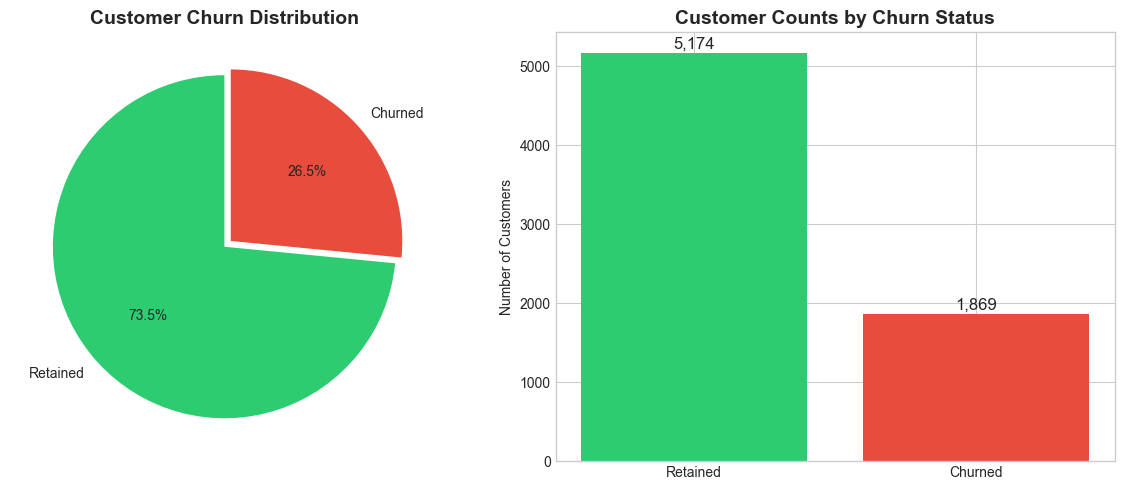

In [7]:
# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(churn_counts, labels=['Retained', 'Churned'], autopct='%1.1f%%',
            colors=colors, explode=(0, 0.05), startangle=90)
axes[0].set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(['Retained', 'Churned'], churn_counts.values, color=colors)
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Customer Counts by Churn Status', fontsize=14, fontweight='bold')
for bar, count in zip(bars, churn_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{count:,}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('../docs/churn_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Feature Analysis & Correlations

In [8]:
# Numeric features summary
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("Numeric Features Summary:")
df[numeric_cols].describe().round(2)

Numeric Features Summary:


,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.73
std,24.56,30.09,2266.79
min,0.00,18.25,0.00
25%,9.00,35.50,398.55
50%,29.00,70.35,1394.55
75%,55.00,89.85,3786.60
max,72.00,118.75,8684.80


In [9]:
# Correlation with churn
print("=" * 50)
print("CORRELATION WITH CHURN")
print("=" * 50)

# Encode categorical for correlation
df_corr = df.copy()
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                    'InternetService', 'Contract', 'PaperlessBilling', 
                    'PaymentMethod']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_cols:
    if col in df_corr.columns:
        df_corr[f'{col}_enc'] = le.fit_transform(df_corr[col].astype(str))

# Get correlations with churn
corr_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen'] + \
            [f'{c}_enc' for c in categorical_cols if f'{c}_enc' in df_corr.columns]

correlations = df_corr[corr_cols + ['Churn_binary']].corr()['Churn_binary'].drop('Churn_binary')
correlations = correlations.sort_values(key=abs, ascending=False)

print("\nCorrelations with Churn (sorted by magnitude):")
for feat, corr in correlations.items():
    direction = 'pos' if corr > 0 else 'neg'
    print(f"  {feat:25} : {corr:+.3f} ({direction})")

CORRELATION WITH CHURN

Correlations with Churn (sorted by magnitude):
  Contract_enc              : -0.397 (neg)
  tenure                    : -0.352 (neg)
  TotalCharges              : -0.198 (neg)
  MonthlyCharges            : +0.193 (pos)
  PaperlessBilling_enc      : +0.192 (pos)
  Dependents_enc            : -0.164 (neg)
  SeniorCitizen             : +0.151 (pos)
  Partner_enc               : -0.150 (neg)
  PaymentMethod_enc         : +0.107 (pos)
  InternetService_enc       : -0.047 (neg)
  PhoneService_enc          : +0.012 (pos)
  gender_enc                : -0.009 (neg)


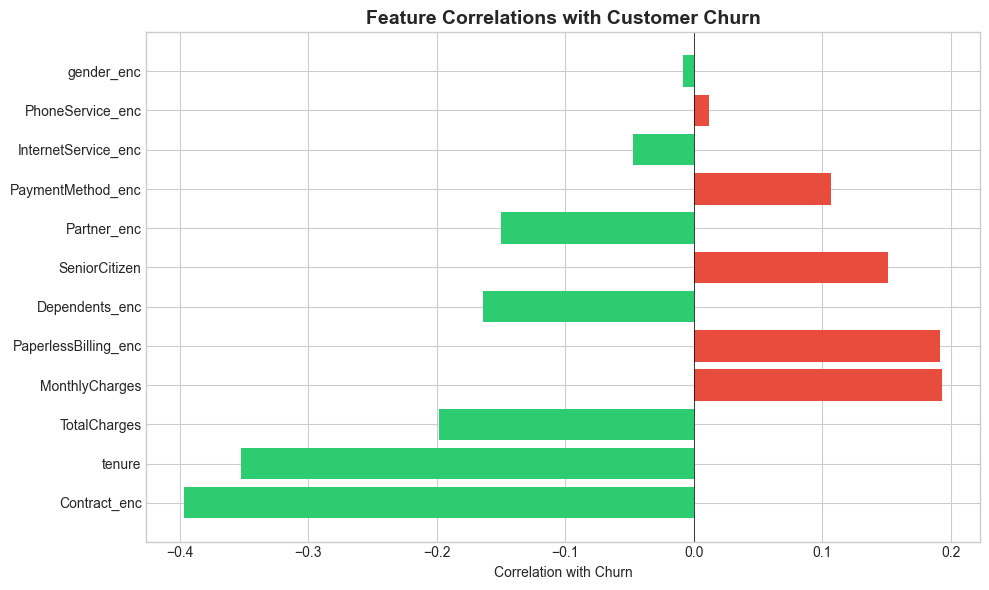

In [10]:
# Visualize correlations
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in correlations.values]
bars = ax.barh(correlations.index, correlations.values, color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Correlation with Churn')
ax.set_title('Feature Correlations with Customer Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Segment Analysis

In [11]:
# Churn by tenure segment
print("=" * 50)
print("CHURN BY CUSTOMER TENURE")
print("=" * 50)

df['tenure_segment'] = pd.cut(df['tenure'], 
                               bins=[0, 6, 12, 24, 48, 72],
                               labels=['0-6 mo', '6-12 mo', '12-24 mo', '24-48 mo', '48+ mo'])

tenure_churn = df.groupby('tenure_segment')['Churn_binary'].agg(['mean', 'count'])
tenure_churn.columns = ['Churn Rate', 'Count']
tenure_churn['Churn Rate'] = tenure_churn['Churn Rate'] * 100

print(tenure_churn.round(2))
print("\nKey Insight: New customers (0-6 months) have the HIGHEST churn rate!")

CHURN BY CUSTOMER TENURE
                Churn Rate  Count
tenure_segment                   
0-6 mo               53.33   1470
6-12 mo              35.89    705
12-24 mo             28.71   1024
24-48 mo             20.39   1594
48+ mo                9.51   2239

Key Insight: New customers (0-6 months) have the HIGHEST churn rate!


C:\Users\Salad\AppData\Local\Temp\ipykernel_95252\2502894964.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('tenure_segment')['Churn_binary'].agg(['mean', 'count'])


In [12]:
# Churn by contract type
print("=" * 50)
print("CHURN BY CONTRACT TYPE")
print("=" * 50)

contract_churn = df.groupby('Contract')['Churn_binary'].agg(['mean', 'count'])
contract_churn.columns = ['Churn Rate', 'Count']
contract_churn['Churn Rate'] = contract_churn['Churn Rate'] * 100

print(contract_churn.round(2))
print("\nKey Insight: Month-to-month contracts have MUCH higher churn!")

CHURN BY CONTRACT TYPE
                Churn Rate  Count
Contract                         
Month-to-month       42.71   3875
One year             11.27   1473
Two year              2.83   1695

Key Insight: Month-to-month contracts have MUCH higher churn!


In [13]:
# Churn by internet service type
print("=" * 50)
print("CHURN BY INTERNET SERVICE")
print("=" * 50)

internet_churn = df.groupby('InternetService')['Churn_binary'].agg(['mean', 'count'])
internet_churn.columns = ['Churn Rate', 'Count']
internet_churn['Churn Rate'] = internet_churn['Churn Rate'] * 100

print(internet_churn.round(2))
print("\nKey Insight: Fiber optic customers churn more - possible quality issues?")

CHURN BY INTERNET SERVICE
                 Churn Rate  Count
InternetService                   
DSL                   18.96   2421
Fiber optic           41.89   3096
No                     7.40   1526

Key Insight: Fiber optic customers churn more - possible quality issues?


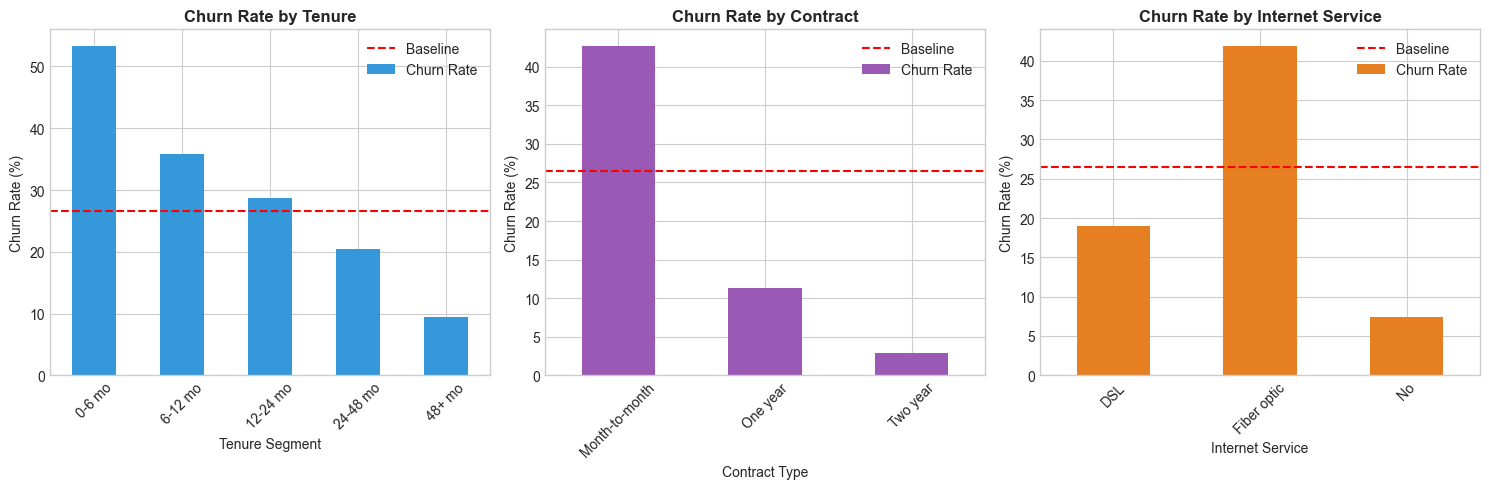

In [14]:
# Visualize segment analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tenure
tenure_churn['Churn Rate'].plot(kind='bar', ax=axes[0], color='#3498db')
axes[0].set_title('Churn Rate by Tenure', fontweight='bold')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_xlabel('Tenure Segment')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=baseline_churn, color='red', linestyle='--', label='Baseline')
axes[0].legend()

# Contract
contract_churn['Churn Rate'].plot(kind='bar', ax=axes[1], color='#9b59b6')
axes[1].set_title('Churn Rate by Contract', fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_xlabel('Contract Type')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=baseline_churn, color='red', linestyle='--', label='Baseline')
axes[1].legend()

# Internet
internet_churn['Churn Rate'].plot(kind='bar', ax=axes[2], color='#e67e22')
axes[2].set_title('Churn Rate by Internet Service', fontweight='bold')
axes[2].set_ylabel('Churn Rate (%)')
axes[2].set_xlabel('Internet Service')
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=baseline_churn, color='red', linestyle='--', label='Baseline')
axes[2].legend()

plt.tight_layout()
plt.savefig('../docs/segment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Generate Synthetic Interventions

This creates the **confounded** intervention data needed for causal inference.
High-risk customers are more likely to receive interventions, which creates selection bias.

In [15]:
from src.simulation import create_confounded_dataset

# Generate synthetic interventions
df_with_interventions = create_confounded_dataset(df, random_state=42)

=== Synthetic Intervention Summary ===
Total customers: 7043
Intervention rate: 35.7%
Churn rate (no intervention): 21.8%
Churn rate (with intervention): 35.0%
Mean treatment effect: 0.249

NOTE: The observed difference is CONFOUNDED - high-risk customers
are more likely to receive intervention. Use causal methods!


In [16]:
# Examine intervention assignment
print("\n" + "=" * 50)
print("INTERVENTION ANALYSIS")
print("=" * 50)

intervention_rate = df_with_interventions['intervention_received'].mean()
print(f"Overall intervention rate: {intervention_rate:.1%}")

# Intervention rate by churn status (showing selection bias)
by_churn = df_with_interventions.groupby('Churn')['intervention_received'].mean()
print(f"\nIntervention rate by churn status:")
for status, rate in by_churn.items():
    print(f"  {status}: {rate:.1%}")

print("\nNote: Higher intervention rate for churners shows SELECTION BIAS!")
print("This is the confounding we need to address with causal inference.")


INTERVENTION ANALYSIS
Overall intervention rate: 35.7%

Intervention rate by churn status:
  No: 31.5%
  Yes: 47.1%

Note: Higher intervention rate for churners shows SELECTION BIAS!
This is the confounding we need to address with causal inference.


In [17]:
# Observed (biased) treatment effect
print("\n" + "=" * 50)
print("OBSERVED (BIASED) TREATMENT EFFECT")
print("=" * 50)

treated_churn = df_with_interventions[df_with_interventions['intervention_received']==1]['churn_observed'].mean()
control_churn = df_with_interventions[df_with_interventions['intervention_received']==0]['churn_observed'].mean()

print(f"Churn rate (treated): {treated_churn:.1%}")
print(f"Churn rate (control): {control_churn:.1%}")
print(f"Observed difference: {treated_churn - control_churn:+.1%}")

print("\nWARNING: This difference is BIASED!")
print("It looks like intervention INCREASES churn, but that's because")
print("high-risk customers are more likely to receive intervention.")
print("\nWe need causal inference methods to get the TRUE effect.")


OBSERVED (BIASED) TREATMENT EFFECT
Churn rate (treated): 35.0%
Churn rate (control): 21.8%
Observed difference: +13.2%

It looks like intervention INCREASES churn, but that's because
high-risk customers are more likely to receive intervention.

We need causal inference methods to get the TRUE effect.


In [18]:
# Save processed dataset
output_path = '../data/processed/churn_with_interventions.csv'
df_with_interventions.to_csv(output_path, index=False)
print(f"Saved processed dataset to: {output_path}")
print(f"Shape: {df_with_interventions.shape}")

Saved processed dataset to: ../data/processed/churn_with_interventions.csv
Shape: (7043, 28)


## Summary

### Key Findings

1. **Baseline churn rate**: ~26.5% (this is what we need to reduce)

2. **High-risk segments**:
   - New customers (0-6 months): ~50% churn
   - Month-to-month contracts: ~40% churn
   - Fiber optic internet: ~40% churn

3. **Key correlations**:
   - Tenure: Strong negative correlation (longer tenure = less churn)
   - Contract type: Longer contracts = less churn
   - Monthly charges: Higher charges = more churn

4. **Confounding in intervention data**:
   - High-risk customers are more likely to receive interventions
   - Observed difference is biased (shows intervention 'increases' churn)
   - Need causal inference to estimate true treatment effect

### Next Steps
- Notebook 02: Build churn prediction model
- Notebook 03: Apply causal inference to estimate true intervention effects